# Brain clasification


---

Dataset merupakan dataset sekunder yang diambil dari Kaggle. Proses deteksi menggunakan metode CNN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
!pip -q install gdown
import gdown
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import cv2
from os import listdir
from sklearn.utils import shuffle

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

## Mendownload dataset kaggle yang disimpan dalam gdrive serta meng-unzip file

In [ ]:
# Define the Google Drive file ID and the destination file name
file_id = '17k6u6gfakGyJtSim_ngkRmNC81YnjCOh'
destination = 'brain_tumor.zip'
url = f'https://drive.google.com/uc?id={file_id}'

# Download the file from Google Drive
gdown.download(url, destination, quiet=False)

# Verify the file type and extract it
try:
    with zipfile.ZipFile(destination, 'r') as zip_ref:
        zip_ref.extractall('content/data')
        print("File extracted successfully.")
except zipfile.BadZipFile as e:
    print(f"Error: {e}. The file may be corrupted or is not a ZIP file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Downloading...
From: https://drive.google.com/uc?id=17k6u6gfakGyJtSim_ngkRmNC81YnjCOh
To: /content/brain_tumor.zip
100%|██████████| 15.8M/15.8M [00:00<00:00, 17.1MB/s]


File extracted successfully.


## Menghapus file asli yang sudah didowload (Untuk menghindari penumpukan file)

In [ ]:
# Remove the downloaded zip file to avoid clutter
os.remove(destination)
print(f"Removed the file: {destination}")

Removed the file: brain_tumor.zip


## Skala dan normalisasi dataset

In [ ]:
def scale_and_normalize(arr):
    """
    Perform Positive Global Standardization on input array and return it.
    Arguments:
        arr: 2-dimensional image array containing int or float values
    Returns:
        arr: positive globally standardized arr of float values
    """
    arr = arr.astype('float32')
    mean, stand_dev = arr.mean(), arr.std()
    arr = (arr - mean) / stand_dev
    arr = np.clip(arr, -1, 1)
    arr = (arr + 1) / 2
    return arr

## Load data

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(os.path.join(directory, filename))

            # convert to grayscale
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # resize image
            image = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_CUBIC)

            # normalize values
            image = scale_and_normalize(image)

            # append to X and y
            X.append(image)
            if 'yes' in directory:
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

# Define directories containing the images
yes_dir = 'content/data/yes'
no_dir = 'content/data/no'
dir_list = [yes_dir, no_dir]

# Load and process the data
image_size = (240, 240)
X, y = load_data(dir_list, image_size)


Number of examples is: 253
X shape is: (253, 240, 240)
y shape is: (253, 1)


## Melihat distribusi data

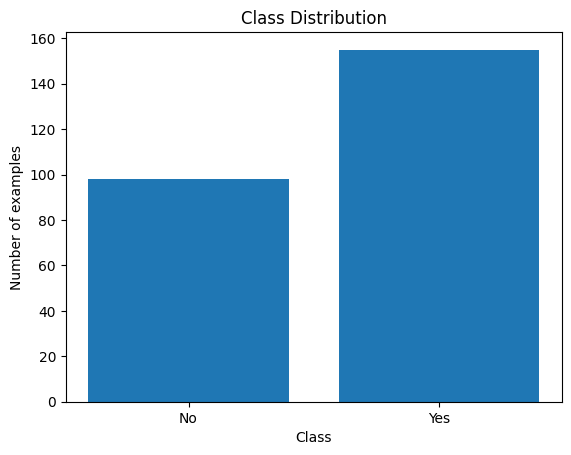

In [ ]:
def plot_class_distribution(y):
    """
    Plot the distribution of classes.
    Arguments:
        y: numpy array of labels
    """
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(unique, counts, tick_label=['No', 'Yes'])
    plt.xlabel('Class')
    plt.ylabel('Number of examples')
    plt.title('Class Distribution')
    plt.show()

# Plot class distribution
plot_class_distribution(y)

## Menampilkan contoh dataset yang sudah dilabeling

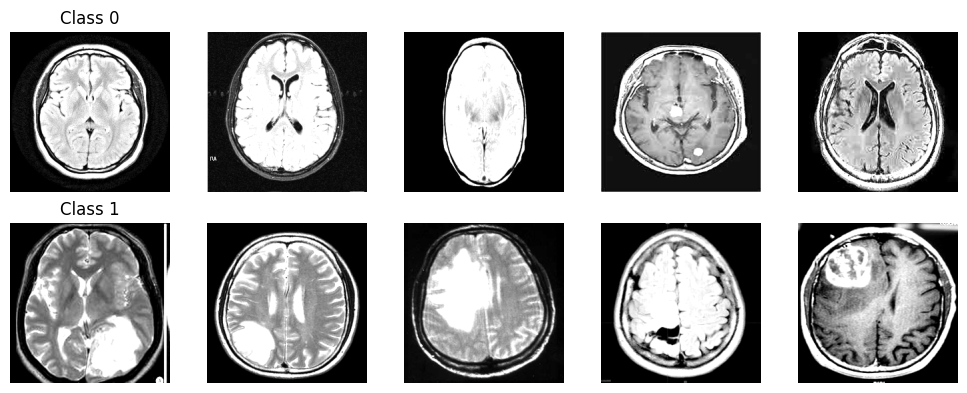

In [ ]:
def plot_sample_images(X, y, num_samples=5):
    """
    Plot sample images from each class.
    Arguments:
        X: numpy array of images
        y: numpy array of labels
        num_samples: number of sample images to show from each class
    """
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 2, len(classes) * 2))

    for i, cls in enumerate(classes):
        class_indices = np.where(y == cls)[0]
        sample_indices = np.random.choice(class_indices, num_samples, replace=False)

        for j, idx in enumerate(sample_indices):
            ax = axes[i, j]
            ax.imshow(X[idx], cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.set_title(f'Class {cls}')

    plt.tight_layout()
    plt.show()

# Plot sample images from each class
plot_sample_images(X, y, num_samples=5)

## Menambah dimensi X untuk training

In [ ]:
# Add channel dimension to X to allow for model training

X = X.reshape(-1, 240, 240, 1)

## Spliting data menjadi train dan test

In [ ]:
# Split data into train and test sets, retain 20% of data for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle=True, stratify=y)

## Augmentasi data

In [ ]:
# Instantiate ImageDataGenerator to perform rotations/flips on training dataset

datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=30,
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          validation_split=.2)

## Pembuatan model CNN

In [ ]:
# Instantiate model

model = keras.models.Sequential([
        keras.Input(shape=(240, 240, 1)),
        keras.layers.Conv2D(32, 3, strides=(1, 1), activation='relu', data_format='channels_last', name='conv0'),
        keras.layers.MaxPool2D((2, 2), name='max_pool0'),
        keras.layers.BatchNormalization(name='bn0'),
        keras.layers.Conv2D(64, 3, strides=(1, 1), activation='relu', data_format='channels_last', name='conv1'),
        keras.layers.MaxPool2D((2, 2), name='max_pool1'),
        keras.layers.BatchNormalization(name='bn1'),
        keras.layers.Conv2D(128, 3, strides=(1, 1), activation='relu', data_format='channels_last', name='conv2'),
        keras.layers.MaxPool2D((2, 2), name='max_pool2'),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-ky0xd8v4
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-ky0xd8v4
  Resolved https://github.com/paulgavrikov/visualkeras to commit 773b971d0ee36128a206be0fc75e76e99fd07085
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 4.8 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=16113 sha256=cfc81bab90730ad7abdf019ea43f4e0c5cbf2ae02e45e02469afe24ee4d9e61a
  Stored in directory: /tmp/pip-ephem-wheel-cache-7xo0gc1f/wheels/89/d3/c2/937382b33c09192fc84331bbc02c4565d62aeae67e9684c37e
Successfully built visualkeras


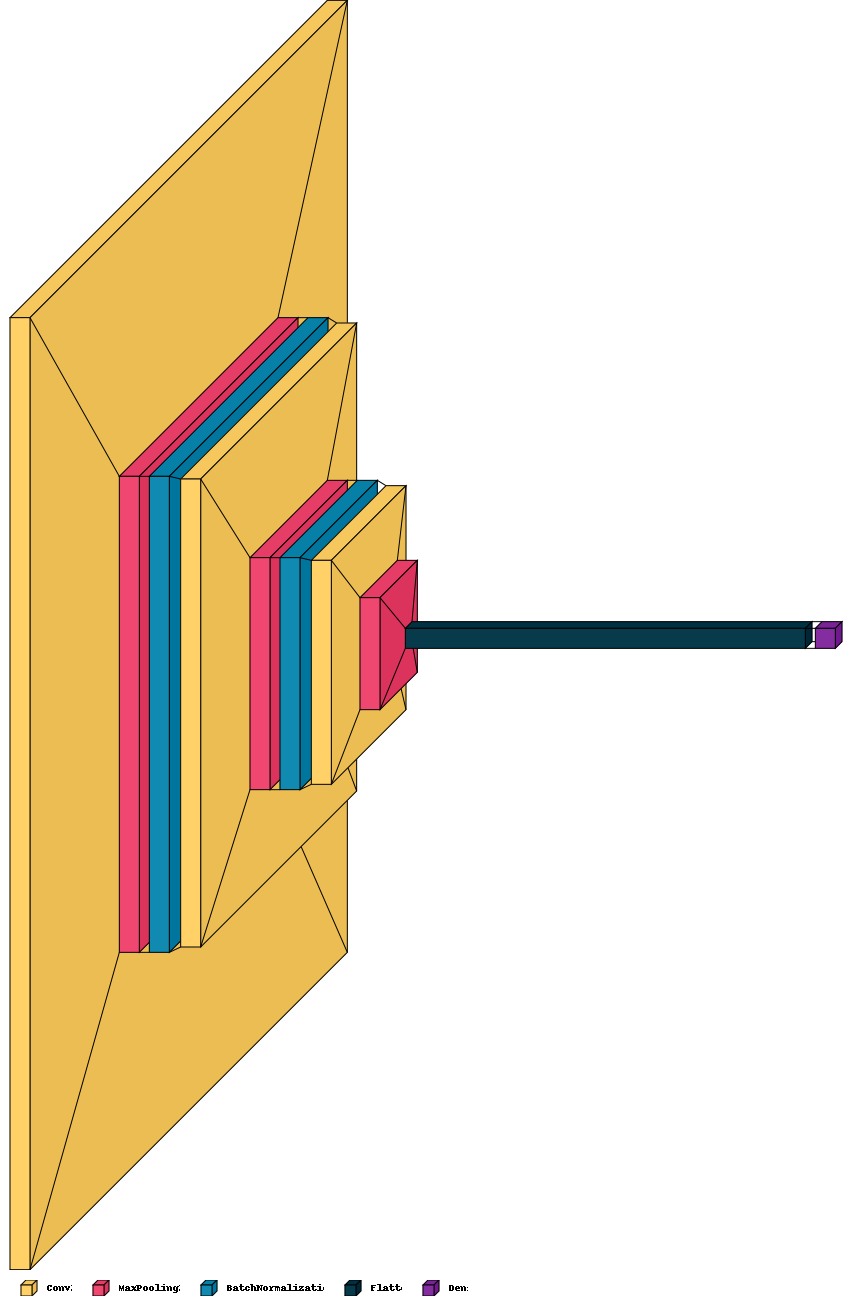

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend=True, one_dim_orientation='z',draw_volume=True)

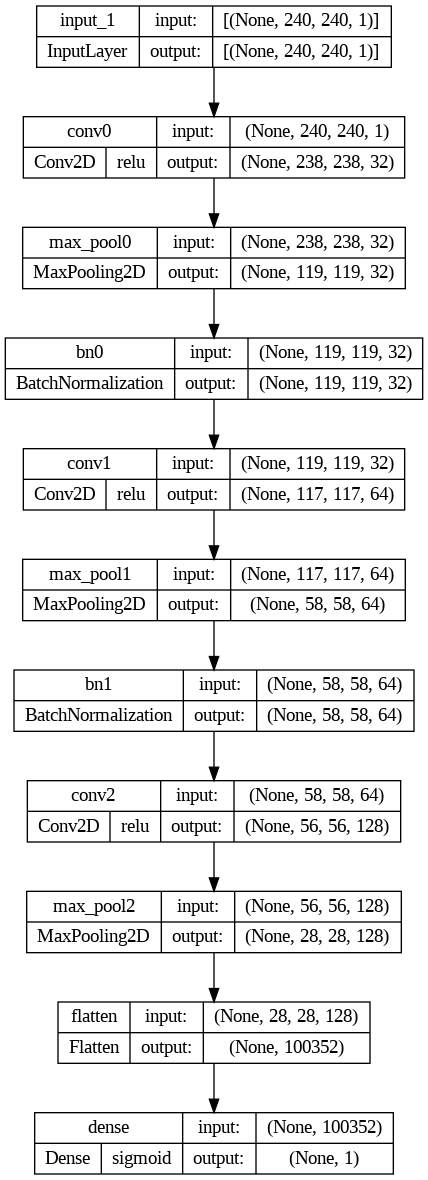

In [ ]:
from tensorflow.keras.utils import plot_model
# Visualisasi model menggunakan plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True )

# Untuk menampilkan gambar dalam Google Colab
from IPython.display import Image
Image('model_plot.png')


In [ ]:
# View summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv0 (Conv2D)              (None, 238, 238, 32)      320       
                                                                 
 max_pool0 (MaxPooling2D)    (None, 119, 119, 32)      0         
                                                                 
 bn0 (BatchNormalization)    (None, 119, 119, 32)      128       
                                                                 
 conv1 (Conv2D)              (None, 117, 117, 64)      18496     
                                                                 
 max_pool1 (MaxPooling2D)    (None, 58, 58, 64)        0         
                                                                 
 bn1 (BatchNormalization)    (None, 58, 58, 64)        256       
                                                                 
 conv2 (Conv2D)              (None, 56, 56, 128)      

## Compile Model

In [ ]:
# Compile model

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['binary_accuracy'])

## Training Dataset

In [ ]:
# Save tensorboard callback logs for each training epoch

from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = 'models/best_classifier.h5'

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Save best model according to its validation set binary accuracy

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

# Fit model using ImageDataGenerator on training data, unaltered testing data

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                       epochs=100, shuffle=True,
                       validation_data = (X_test, y_test),
                       callbacks=[tensorboard_callback, model_checkpoint_callback])

Epoch 1/100
7/7 [==============================] - 6s 182ms/step - loss: 140.8812 - binary_accuracy: 0.5000 - val_loss: 251.4546 - val_binary_accuracy: 0.3922
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 142ms/step - loss: 275.0352 - binary_accuracy: 0.5050 - val_loss: 120.0796 - val_binary_accuracy: 0.6471
Epoch 3/100
7/7 [==============================] - 1s 144ms/step - loss: 194.2416 - binary_accuracy: 0.5941 - val_loss: 166.8045 - val_binary_accuracy: 0.6667
Epoch 4/100
7/7 [==============================] - 1s 134ms/step - loss: 128.1257 - binary_accuracy: 0.6980 - val_loss: 230.1349 - val_binary_accuracy: 0.4314
Epoch 5/100
7/7 [==============================] - 1s 165ms/step - loss: 71.6906 - binary_accuracy: 0.6782 - val_loss: 237.5252 - val_binary_accuracy: 0.4314
Epoch 6/100
7/7 [==============================] - 1s 207ms/step - loss: 39.8678 - binary_accuracy: 0.7921 - val_loss: 31.4447 - val_binary_accuracy: 0.6863
Epoch 7/100
7/7 [==============================] - 2s 255ms/step - loss: 21.6292 - binary_accuracy: 0.7376 - val_loss: 11.3158 - val_binary_accuracy: 0.7255
Epoch 8/100
7/7 [==============================] - 1s 136ms/ste

## Memantau loss dan accuracy

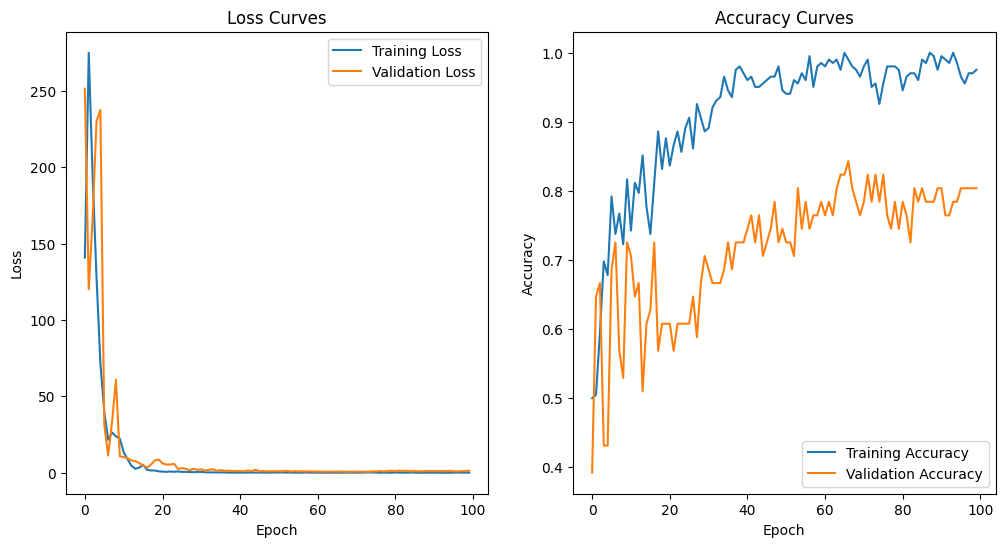

In [ ]:
# Retrieve the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Retrieve the training and validation accuracy values
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()


# Plot the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()


In [ ]:
# Print final training and validation accuracy and loss
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

print(f"Final Training Accuracy: {final_train_acc:.2%}")
print(f"Final Validation Accuracy: {final_val_acc:.2%}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Accuracy: 97.52%
Final Validation Accuracy: 80.39%
Final Training Loss: 0.0546
Final Validation Loss: 1.3632


## Melihat hasil klasifikasi

2/2 [==============================] - 0s 16ms/step


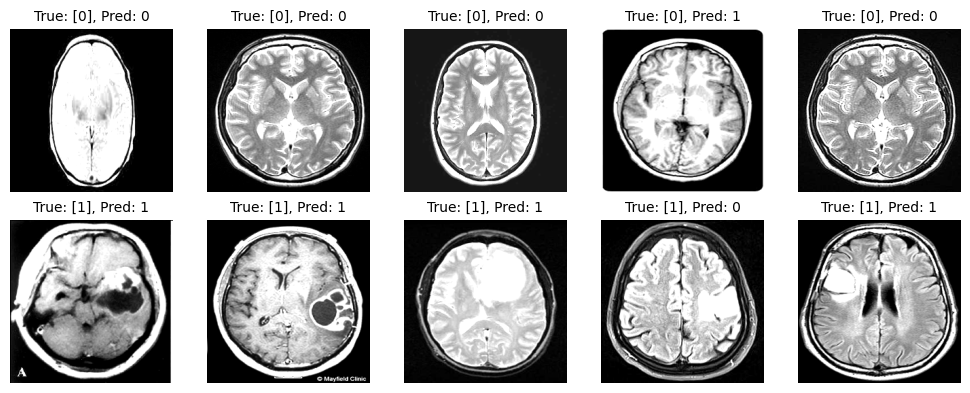

In [ ]:
def plot_classification_results(model, X_test, y_test, num_samples=5):
    """
    Plot classification results on test data.
    Arguments:
        model: trained keras model
        X_test: numpy array of test images
        y_test: numpy array of test labels
        num_samples: number of sample images to show from each class
    """
    predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

    classes = np.unique(y_test)

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 2, len(classes) * 2))

    for i, cls in enumerate(classes):
      class_indices = np.where(y_test == cls)[0]
      sample_indices = np.random.choice(class_indices, num_samples, replace=False)

      for j, idx in enumerate(sample_indices):
            ax = axes[i, j]
            ax.imshow(X_test[idx], cmap='gray')
            ax.axis('off')
            true_label = y_test[idx]
            pred_label = predictions[idx]
            ax.set_title(f'True: {true_label}, Pred: {pred_label}', fontsize=10)

    plt.tight_layout()
    plt.show()

# Plot classification results
plot_classification_results(model, X_test, y_test, num_samples=5)

## Evaluasi model

2/2 [==============================] - 0s 16ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.95      0.79        20
           1       0.96      0.71      0.81        31

    accuracy                           0.80        51
   macro avg       0.82      0.83      0.80        51
weighted avg       0.85      0.80      0.81        51



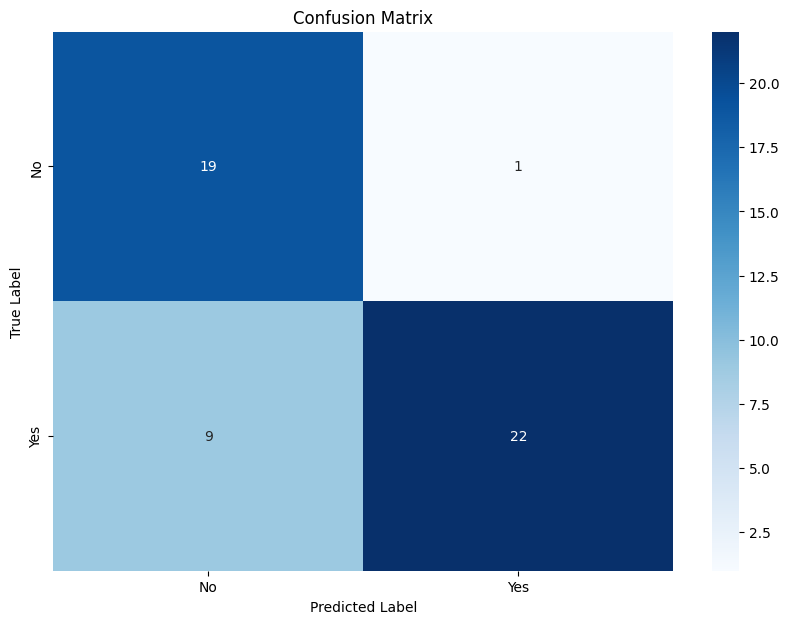

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification Report
print('Classification Report')
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class names
class_names = ['No', 'Yes']

# Convert confusion matrix to a pandas dataframe
confusion_df = pd.DataFrame(data=conf_matrix, index=class_names, columns=class_names)

# Set the names of the x and y axis, this helps with the readability of the heatmap
confusion_df.index.name = 'True Label'
confusion_df.columns.name = 'Predicted Label'

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Brain Tumor detection Menggunakan model yang sudah ada (MobileNet)

Number of examples is: 253
X shape is: (253, 224, 224)
y shape is: (253,)
17225924/17225924 [==============================] - 2s 0us/step
Epoch 1/10
7/7 [==============================] - 5s 336ms/step - loss: 0.9936 - binary_accuracy: 0.5545 - val_loss: 0.5148 - val_binary_accuracy: 0.6667
Epoch 2/10
7/7 [==============================] - 1s 104ms/step - loss: 0.5266 - binary_accuracy: 0.7178 - val_loss: 0.4689 - val_binary_accuracy: 0.7059
Epoch 3/10
7/7 [==============================] - 1s 105ms/step - loss: 0.3890 - binary_accuracy: 0.7970 - val_loss: 0.2989 - val_binary_accuracy: 0.8235
Epoch 4/10
7/7 [==============================] - 1s 97ms/step - loss: 0.2698 - binary_accuracy: 0.9059 - val_loss: 0.2602 - val_binary_accuracy: 0.9020
Epoch 5/10
7/7 [==============================] - 1s 91ms/step - loss: 0.2161 - binary_accuracy: 0.9307 - val_loss: 0.2278 - val_binary_accuracy: 0.9216
Epoch 6/10
7/7 [==============================] - 0s 64ms/step - loss: 0.1957 - binary_accura

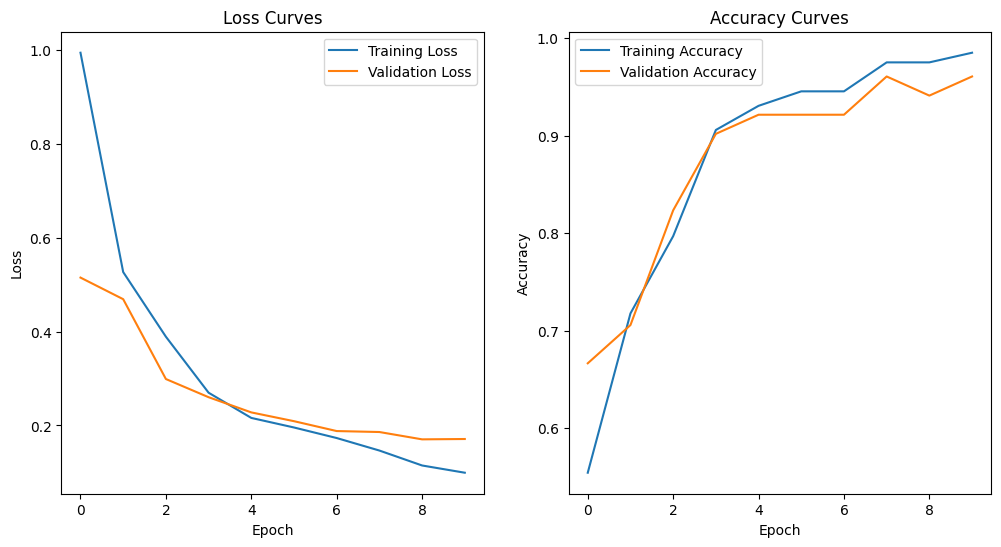

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNet

def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # Load the image
            image = cv2.imread(os.path.join(directory, filename))

            # Convert to grayscale
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Resize image
            image = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_CUBIC)

            # Normalize values
            image = scale_and_normalize(image)

            # Append to X and y
            X.append(image)
            if 'yes' in directory:
                y.append(1)
            else:
                y.append(0)

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

# Define directories containing the images
yes_dir = 'content/data/yes'
no_dir = 'content/data/no'
dir_list = [yes_dir, no_dir]

# Load and process the data
image_size = (224, 224)  # Change to the required image size
X, y = load_data(dir_list, image_size)

# Expand dimensions to match the input shape of the model
X = np.expand_dims(X, axis=-1)
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to RGB by repeating the grayscale channel


# Split the data into training and testing sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Prepare directories for saving logs and model checkpoints
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = 'models/best_classifier.h5'

# Define callbacks
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True
)

# Load the MobileNet model without the top layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[tensorboard_callback, model_checkpoint_callback])

# Retrieve the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Retrieve the training and validation accuracy values
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

# Print final training and validation accuracy and loss
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

print(f'Final Training Accuracy: {final_train_acc:.2%}')
print(f'Final Validation Accuracy: {final_val_acc:.2%}')
print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()


# Plot the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()


2/2 [==============================] - 0s 43ms/step


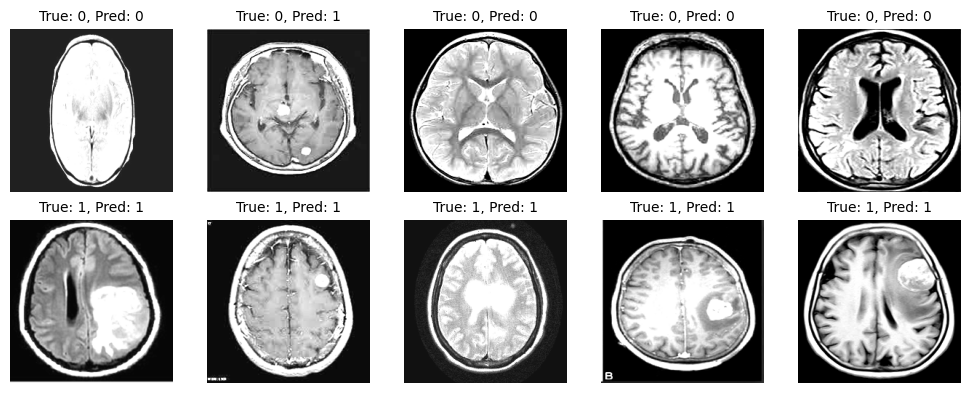

In [ ]:
# Plot classification results on test data
plot_classification_results(model, X_test, y_test, num_samples=5)